In [1]:
#lets load all the neccesory libararies
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import pyplot
from scipy.stats import norm
import datetime as dt

### First and foremost we will load the data and explore it

In [2]:
# loading the data
Natgas = pd.read_csv("/content/Nat_Gas.csv")


In [3]:
# checking wheather the data is imported properly or not by look at first 10 rows
Natgas.head(10)

,Dates,Prices
0,10/31/20,10.10
1,11/30/20,10.30
2,12/31/20,11.00
3,1/31/21,10.90
4,2/28/21,10.90
5,3/31/21,10.90
6,4/30/21,10.40
7,5/31/21,9.84
8,6/30/21,10.00
9,7/31/21,10.10


In [4]:
#converting all dates in into Datetime formate
Natgas['Dates'] = pd.to_datetime(Natgas['Dates'], format="%m/%d/%y")

In [5]:
Natgas.index

RangeIndex(start=0, stop=48, step=1)

In [6]:
#checking basic information about the data, No. of sample, datype and basics
Natgas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Dates   48 non-null     datetime64[ns]
 1   Prices  48 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 900.0 bytes


In [7]:
#lets check is their any null or missing value in the dataset
Natgas.isnull().any()

,0
Dates,False
Prices,False


In [8]:
#now we know their is no null value lets check basic stats of the data
Natgas['Prices'].describe().T

,Prices
count,48.000000
mean,11.207083
std,0.757897
min,9.840000
25%,10.650000
50%,11.300000
75%,11.625000
max,12.800000


Text(0.5, 0, 'Dates')

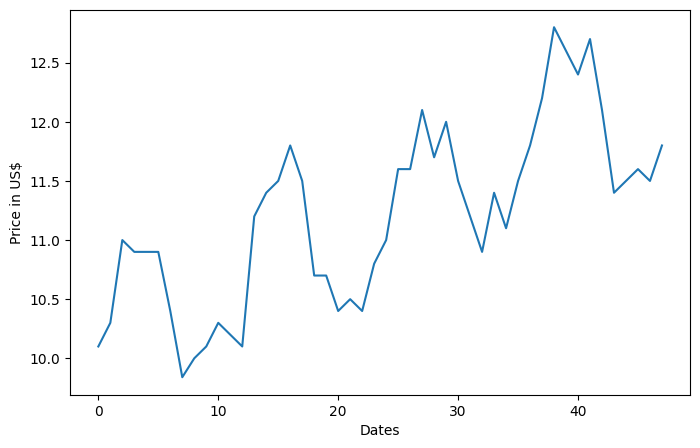

In [9]:
#lets visualise the price trend in the of all given timeperiod
Axes = Natgas['Prices'].plot(figsize = (8,5))
Axes.set_ylabel("Price in US$")
Axes.set_xlabel("Dates")


In [10]:
print(Natgas.index)

RangeIndex(start=0, stop=48, step=1)


###We have created three different Exponantial Moving average features:
#### 3 months,  "Quarterly"for Short term momentum
#### 6 months for balancing between short reactivity and long term stability  in price
#### 12 months "Annually" for broad market seasonal price cycle

In [11]:
Natgas['EMA_3'] = Natgas['Prices'].ewm(span = 3, adjust= False).mean()
Natgas['EMA_6'] = Natgas['Prices'].ewm(span= 6, adjust = False).mean()
Natgas['EMA_12'] = Natgas['Prices'].ewm(span= 12, adjust = False).mean()

In [12]:
#let review our new feature which we have created  moving averages of diff time horizan
Natgas.head()


,Dates,Prices,EMA_3,EMA_6,EMA_12
0,2020-10-31,10.1,10.100,10.100000,10.100000
1,2020-11-30,10.3,10.200,10.157143,10.130769
2,2020-12-31,11.0,10.600,10.397959,10.264497
3,2021-01-31,10.9,10.750,10.541399,10.362267
4,2021-02-28,10.9,10.825,10.643857,10.444995


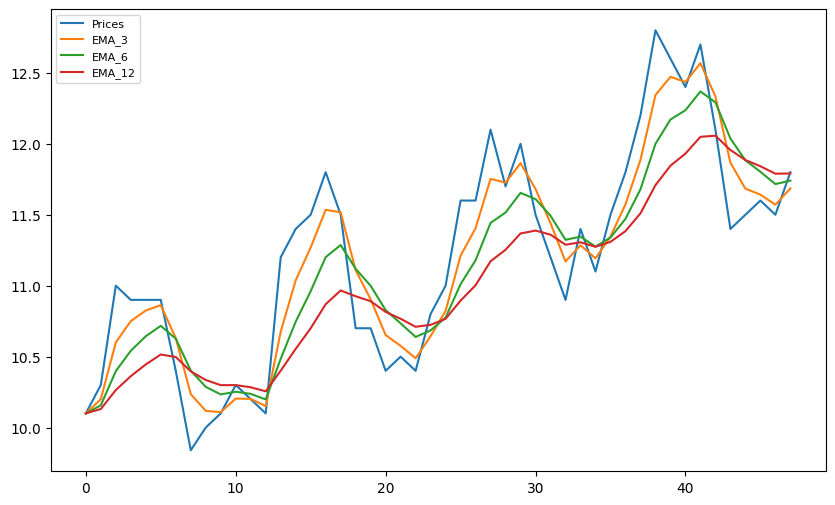

In [13]:
Natgas.loc[:,['Prices', 'EMA_3', 'EMA_6', 'EMA_12',]].plot(figsize=(10,6))
plt.legend(loc ="upper left", fontsize = 8)
plt.show()


## In Time-series we often have three components
#### Trend Seasonality, and Residuals
#### In the Muliplicative Model we assume:
####         Time-Sesires = Trend * Seasonality * Residuals
#### Where,
#### Trend shows the long-run direction( Ups, down or sidebyside price nature)

#### Seasonal shows regular, repeating patterns (Year Start and End peaks, Mid year Trough)
#### Residual or irregular shows random noise in price


In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
# decompose  the multiplicative model by using seasonal cycle time period which is 12 months
result = seasonal_decompose(Natgas['Prices'], model='multiplicative', period=12)





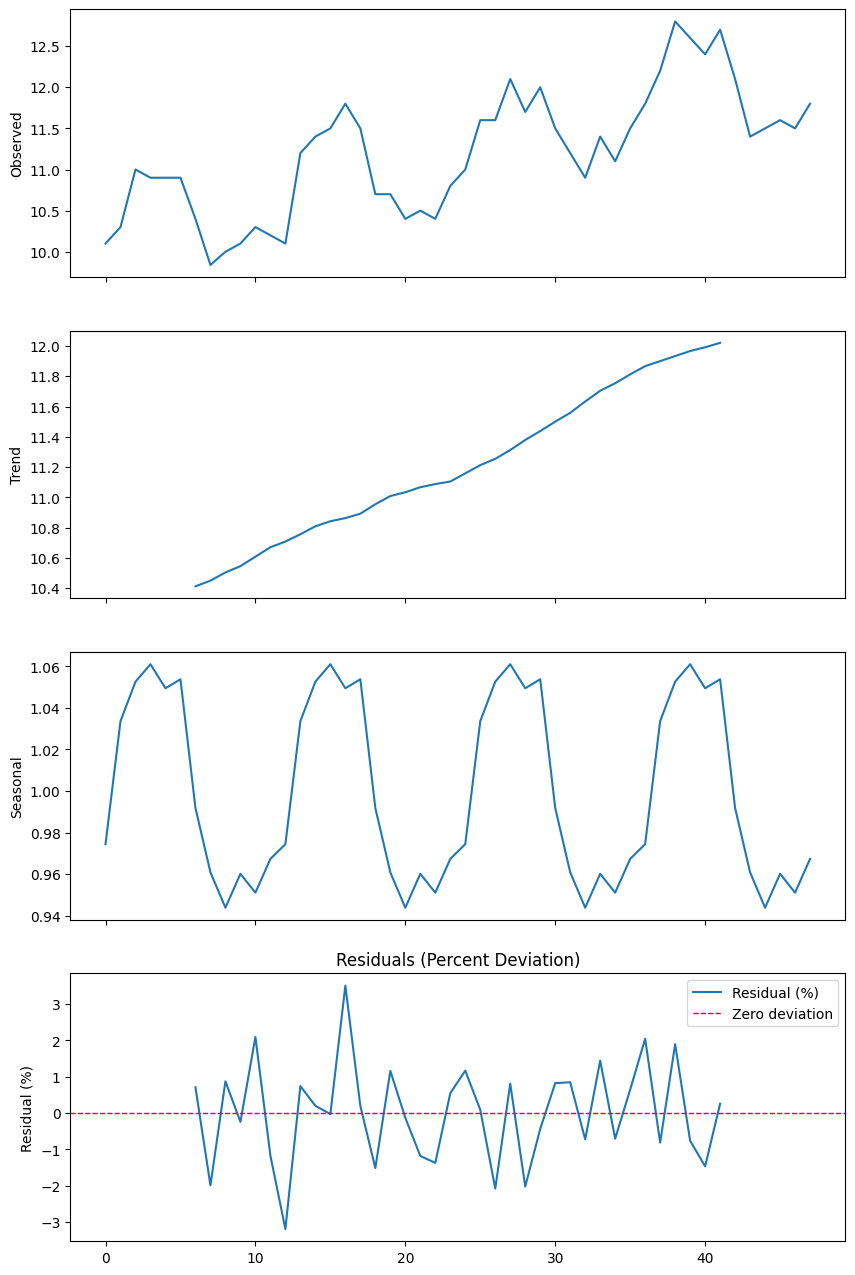

In [15]:
# let customise our visuals all all  of the 4 feature will have same dates but different scales
fig, axes = plt.subplots(4, 1, figsize=(10,16 ), sharex=True)

#Observed
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel("Observed")

# Trend
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel("Trend")

#Seasonal
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel("Seasonal")


# Residual panel
axes[3].set_title("Residuals (Percent Deviation)")
((result.resid - 1) * 100).plot(ax=axes[3], label="Residual (%)")
axes[3].axhline(0, color="red", linestyle="--", linewidth=1, label="Zero deviation")
axes[3].set_ylabel("Residual (%)")
axes[3].legend(loc="upper right")



In [16]:
# lets check residuals stats
resid = result.resid.dropna()
print(resid.describe().T)


count    36.000000
mean      1.000056
std       0.013975
min       0.968016
25%       0.990954
50%       1.001431
75%       1.008295
max       1.035111
Name: resid, dtype: float64


### Our Analysis on the basis of Mulitiplicative mode results:
#####  Observed already known, plotted just for reference
##### Trend Component: Shows a clear upward movement over time, indicating that the underlying price levels evolve gradually increase.
##### Seasonality Comp: Displays a consistent repeating pattern every 12 periods (monthly cycle), confirming strong seasonal behavior in natural gas prices.
##### Residual Comp :
###### °Centered around the zero-deviation line (1.0 in multiplicative model)
###### °No visible autocorrelation or pattern left in the residuals
###### °Standard deviation is low ~1.4% , with residuals mostly within ±3.5%, which is statistically acceptable
###### °This indicates that the decomposition captured most of the signal, leaving some random noise behind


#### Let check wheather the Time-Series is Stationary or not before building a model  
##### To do that we will do ADF( Augmented Dickey-Fuller) test

In [17]:
#Importing the ADF test function from the statsmodels library
from statsmodels.tsa.stattools import adfuller


# Running the ADF Test on Price
result = adfuller(Natgas['Prices'])

# visualising the results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")


ADF Statistic: 0.21807686169999427
p-value: 0.973257438844869
Critical Values:
   1%: -3.6209175221605827
   5%: -2.9435394610388332
   10%: -2.6104002410518627


###### From our result we get know series  of prices is not stationary;
###### Because,
ADF is 0.218.. is greater then all critical value basically is not negative enough

p-value is 0.973, >> 0.5, which is not good should needs to be under 0.5

**Now we gonna try First-order differenceing to make stationary which is basically common approach**

In [18]:
Natgas['Price_diff'] = Natgas['Prices'].diff().dropna()

In [19]:
# importing the augmented Dickey-Fuller test from statsmodels
from statsmodels.tsa.stattools import adfuller
# Running the ADF test on the diff prices basically  dropping NaN values if there is any
result_diff = adfuller(Natgas['Price_diff'].dropna())
print("ADF Statistic:", result_diff[0])
print("p-value:", result_diff[1])
# print the critical values for different confidence levels 1%, 5%, and 10%
for key, value in result_diff[4].items():
    print(f"   {key}: {value}")


ADF Statistic: -6.844773557477344
p-value: 1.754169685294091e-09
   1%: -3.6209175221605827
   5%: -2.9435394610388332
   10%: -2.6104002410518627


As you can see above we got very small p-value 1.75e-09 and ADF negative -6.844 shows its very smaller then critical value

**We get know that the differenced Time series is Stationary**

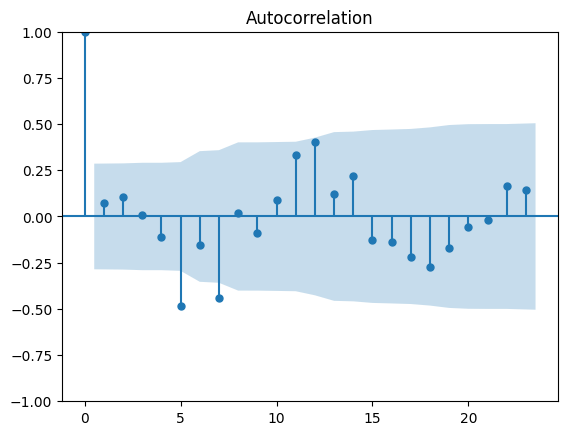

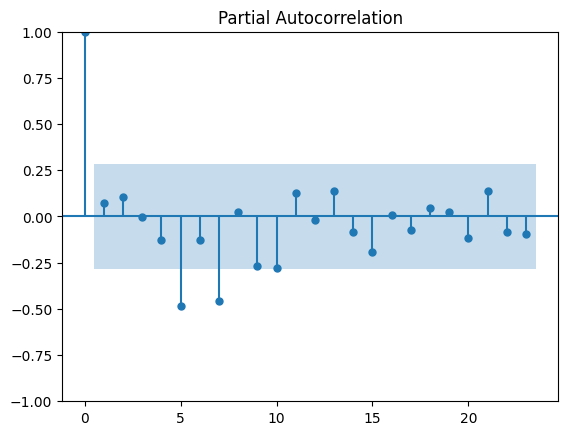

In [20]:
#importing auto-and-partial autocorrelation fucntion
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#visualise ACF
plot_acf(Natgas['Price_diff'].dropna(), lags=23)
#visualise PACF
plot_pacf(Natgas['Price_diff'].dropna(), lags=23)
plt.show()


**the ARIMA model**
#####order = (p, d, q)
#####p = number of autoregressive terms (lags)
#####d = number of differences (to make data stationary)
#####q = number of moving average terms

                               SARIMAX Results                                
Dep. Variable:                 Prices   No. Observations:                   48
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -22.151
Date:                Wed, 11 Jun 2025   AIC                             50.303
Time:                        09:34:53   BIC                             55.853
Sample:                             0   HQIC                            52.391
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3718      1.748      0.213      0.832      -3.054       3.798
ma.L1         -0.2817      1.787     -0.158      0.875      -3.784       3.221
sigma2         0.1502      0.031      4.822      0.0

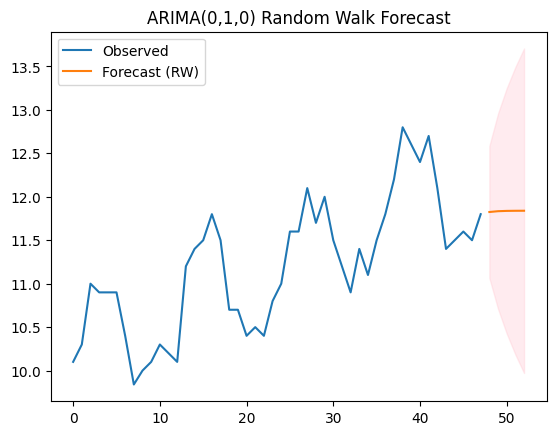

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                 Prices   No. Observations:                   48
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  51.465
Date:                Wed, 11 Jun 2025   AIC                            -90.931
Time:                        09:34:54   BIC                            -79.830
Sample:                             0   HQIC                           -86.753
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
EMA_3          3.3290      0.115     29.006      0.000       3.104       3.554
EMA_6         -4.4791      0.264    -16.969      0.000      -4.996      -3.962
EMA_12         2.2298      0.175     12.775      0.0

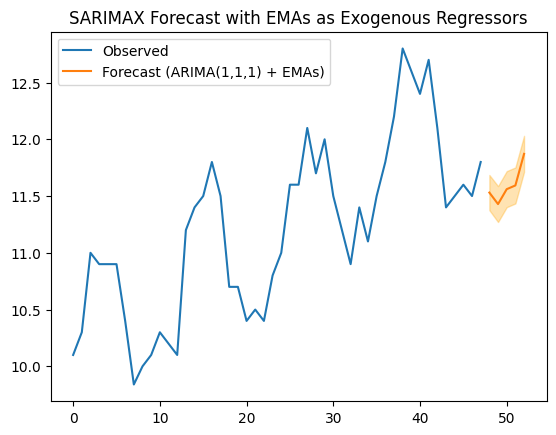

In [21]:
#importing the arima Model and matplotlib
from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt

# plot observed data
plt.plot(Natgas['Prices'], label='Observed')

# 1. Fit ARIMA(0,1,0) p-0,d-1 and, q-0 without drift (random walk)
model_rw = ARIMA(Natgas['Prices'], order=(1, 1, 1), trend='n')
fit_rw = model_rw.fit()
print(fit_rw.summary())

# forecast next 5 steps
forecast_rw = fit_rw.get_forecast(steps=5)
#forecast with confidence interval
forecast_rw_df = forecast_rw.summary_frame()

# plot forcasted value
plt.plot(range(len(Natgas), len(Natgas) + 5), forecast_rw_df['mean'], label='Forecast (RW)')
# adding confidence interval
plt.fill_between(
    range(len(Natgas), len(Natgas) + 5),
    forecast_rw_df['mean_ci_lower'],
    forecast_rw_df['mean_ci_upper'],
    color='pink', alpha=0.3
)
#final plot
plt.legend()
plt.title('ARIMA(0,1,0) Random Walk Forecast')
plt.show()

#-------------------------------------------------------------------------------
# 2 Fit ARIMA(1,1,1) with exogenous variables (EMAs used as predictors)
#let import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Drop NaN rows created by EMA calculations
Natgas_model = Natgas.dropna(subset=['EMA_3', 'EMA_6', 'EMA_12'])

# Define targeted variable (endogenous) and predictors (exogenous variables)
y = Natgas_model['Prices']
X = Natgas_model[['EMA_3', 'EMA_6', 'EMA_12']]


# 2. SARIMAX model with EMAs as exogenous variables (ARIMA(1,1,1)


model_exog = SARIMAX(y, exog=X, order=(1, 1, 1), enforce_stationarity=True, enforce_invertibility=True)

fit_exog = model_exog.fit(disp=False)
print(fit_exog.summary())

# PREPARING 5 MOST RECENT ema SAMPLES TO Forcast next 5
X_forecast = X.iloc[-5:].copy()

#forcast using exogenouse model
forecast_exog = fit_exog.get_forecast(steps=5, exog=X_forecast)
forecast_exog_df = forecast_exog.summary_frame()

# Plot predicted price using exogenous input
plt.plot(y, label='Observed')
plt.plot(range(len(y), len(y) + 5), forecast_exog_df['mean'], label='Forecast (ARIMA(1,1,1) + EMAs)')
#adding confidence interval
plt.fill_between(
    range(len(y), len(y) + 5),
    forecast_exog_df['mean_ci_lower'],
    forecast_exog_df['mean_ci_upper'],
    color='orange', alpha=0.3
)
#finally plot the result
plt.title('SARIMAX Forecast with EMAs as Exogenous Regressors')
plt.legend()
plt.show()


**Model Summary**
#### 1.ARIMA(1,1,1) without exogenous variables:

*   This model tries to capture the price changes with one autoregressive (AR) and one moving average (MA) term after differencing once.
*   The AR and MA coefficients have large standard errors and are statistically insignificant (p-values > 0.8), indicating weak explanatory power.
*   Sigma² (variance of residuals) is 0.1502, indicating the noise level around the model predictions.
AIC = 50.303, which provides a baseline metric for model comparison.
*   Residual diagnostics:
 *     Ljung-Box test p-value = 0.86 suggests no significant autocorrelation in residuals — residuals behave like white noise.
 *     Jarque-Bera p-value = 0.94 implies residuals are normally distributed, supporting model adequacy.
*   A convergence warning suggests the optimization algorithm had some difficulty fitting the model perfectly.

This model tries to capture the price changes with one autoregressive (AR) and one moving average (MA) term after differencing once.



#### 2. SARIMAX(1,1,1) with EMAs as exogenous regressors:

* This model includes three exponential moving averages (EMA_3, EMA_6, EMA_12) as predictors along with ARIMA(1,1,1) structure.
* EMA coefficients are highly significant (p < 0.001), indicating these features strongly influence price movements.
* AR and MA terms have moderate significance; MA is statistically significant (p = 0.008).
* Sigma² is smaller (0.0062), indicating less residual variance and a better fit.
*AIC = -90.931, much lower than the simple ARIMA, showing a substantially better model.
* Residual diagnostics:
  * Ljung-Box p = 0.58 indicates no significant autocorrelation in residuals.
  * Jarque-Bera p = 0.67 indicates residuals are approximately normal.
* The convergence warning remains but model fit and statistical significance are greatly improved.

**Analysis**

*The simple ARIMA(1,1,1) model fits the data weakly and parameters are not significant, suggesting it does not capture key dynamics.
* Including EMAs as exogenous regressors in SARIMAX improves fit drastically, reduces residual variance, and yields highly significant explanatory variables.
* Both models show good residual diagnostics, indicating reliable inference.
* Convergence warnings suggest trying more iterations or alternative optimizers could improve stability but results are still interpretable.
* The SARIMAX model confirms that technical indicators like EMAs contain valuable information beyond simple random walk assumptions.



In [22]:
#we making sure that all the columns and their names are on thier exact place
Natgas.reset_index(inplace = True)

In [23]:
Natgas.columns

Index(['index', 'Dates', 'Prices', 'EMA_3', 'EMA_6', 'EMA_12', 'Price_diff'], dtype='object')

In [24]:
#droping index columns as we use date as an index
Natgas.drop('index', axis =1, inplace = True)


In [25]:
#setting date as an index
Natgas = Natgas.sort_values("Dates")
Natgas.set_index('Dates', inplace = True)


In [26]:
Natgas.head()

,Prices,EMA_3,EMA_6,EMA_12,Price_diff
Dates,,,,,
2020-10-31,10.1,10.100,10.100000,10.100000,NaN
2020-11-30,10.3,10.200,10.157143,10.130769,0.2
2020-12-31,11.0,10.600,10.397959,10.264497,0.7
2021-01-31,10.9,10.750,10.541399,10.362267,-0.1
2021-02-28,10.9,10.825,10.643857,10.444995,0.0


As you can see now the data Coloumn has become the Index now

In [27]:
#Defining the Daily range between first and last month ends
first_hist = Natgas.index.min()
last_hist= Natgas.index.max()

# lets create a list of all dates from first to last date with daily frequency
daily_index_hist= pd.date_range(first_hist, last_hist, freq = 'D')

In [28]:
#reindexing monthly data into daily index
hist_daily = Natgas[['Prices']].reindex(daily_index_hist)

In [29]:
#linearly interpolating so every day will have price
hist_daily['Prices'] = hist_daily['Prices'].interpolate(method= 'time')

In [30]:
#chechking daily price in same month as we created daily data feature above
hist_daily.loc['2021-03-01':'2021-03-05']


,Prices
2021-03-01,10.9
2021-03-02,10.9
2021-03-03,10.9
2021-03-04,10.9
2021-03-05,10.9


In [52]:
#just making sure that there is no null values before training
forecast_monthly.isnull().any()

,0
Price_forecasted,False


**Now our "hist_daily" now correctly fills in every calendar day from 2020-10-31 to 2024-09-30, we can move on to the Model fitting to forcast for 12 months**

In [31]:
#importing the model
from statsmodels.tsa.arima.model import ARIMA
#creating the ARIMA(1,1,1) model
model_drift = ARIMA(Natgas['Prices'], order = (1,1,1), trend = 't')
fit_drift = model_drift.fit()
fit_drift.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Prices   No. Observations:                   48
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -21.977
Date:                Wed, 11 Jun 2025   AIC                             51.953
Time:                        09:34:55   BIC                             59.354
Sample:                    10-31-2020   HQIC                            54.738
                         - 09-30-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0377      0.067      0.565      0.572      -0.093       0.169
ar.L1          0.3609      2.046      0.176      0.860      -3.650       4.372
ma.L1         -0.2769      2.087     -0.133      0.894      -4.368       3.814
sigma2         0.1491      0.032      4.693      0.000       0.087       0.211
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.12
Prob(Q):                              0.89   Prob(JB):                         0.94
Heteroskedasticity (H):               0.96   Skew:                             0.12
Prob(H) (two-sided):                  0.93   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
#BUIDLING FUNCTION  t give  prediction for 12 months
forecast_12 = fit_drift.get_forecast(steps =12)
forecast_12_df = forecast_12.summary_frame()

#building 12 months end dates for predictions
last_hist_date =  Natgas.index.max()
future_months_ends = pd.date_range(start = last_hist_date + pd.offsets.MonthEnd(1),
                                   periods=12, freq= 'M')

# Now we have to attach the above dates and keep only the point forcast,mean
forecast_12_df = forecast_12_df.assign(Date = future_months_ends).set_index("Date")
forecast_monthly = forecast_12_df[["mean"]].rename(columns ={"mean":"Price_forecasted"})

#let review them
forecast_monthly



<ipython-input-32-3548488900>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_months_ends = pd.date_range(start = last_hist_date + pd.offsets.MonthEnd(1),


Prices,Price_forecasted
Date,
2024-10-31,11.856631
2024-11-30,11.901179
2024-12-31,11.941364
2025-01-31,11.979976
2025-02-28,12.018019
2025-03-31,12.055857
2025-04-30,12.093622
2025-05-31,12.131359
2025-06-30,12.169087


In [33]:
#as we can see here Date and Prices columns is overlapping to solve this we will reset the index
forecast_monthly.reset_index(inplace = True)
forecast_monthly.columns


Index(['Date', 'Price_forecasted'], dtype='object', name='Prices')

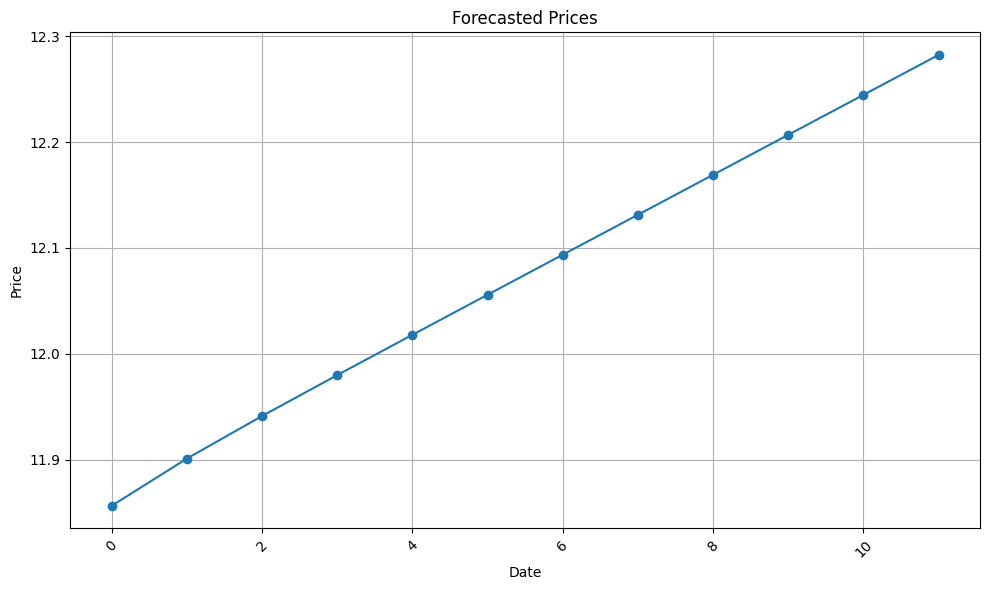

In [34]:
#also we will visualise these forcast
plt.figure(figsize = (10,6))
plt.plot(forecast_monthly.index, forecast_monthly['Price_forecasted'], marker ='o')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Forecasted Prices")


# Optional: Rotate x-axis labels for clarity
plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

as you can see there is uptrend (Bullish trend) over the period of predicton

**letter on we will compare them with orignal price aswell**

**Now lets Combine historical + forecasted into one full daily series**

In [35]:
#interpolating the forcasted monthly data to daily
forecast_daily = forecast_monthly.set_index('Date').resample('D').interpolate("linear")

#now lets combine the hist + future
full_series = pd.concat([hist_daily, forecast_daily])
full_series = full_series[~full_series.index.duplicated()].sort_index()

In [36]:
# now let define a function
import pandas as pd
# creating function which will take data as input
def get_price_estimate(date_str):
    """
    Given a date string in 'YYYY-MM-DD', returns the estimated natural gas price.
    """
    import pandas as pd
#program will check is the input is in date formate or not
    date = pd.to_datetime(date_str)

    if date in full_series.index:
      return round(full_series.loc[date, "Prices"],3)
    else:
      return f"Date{date_str} is out of supported range ({full_series.index.min().date()} to{full_series.index.max().date()})."

In [37]:
#we converting data into datetime formae just incase
forecast_monthly['Date'] = pd.to_datetime(forecast_monthly['Date'])
#setting date as an index
forecast_monthly.set_index("Date", inplace = True)
#keeping only one coloumn which is price_forcasted data we have as an index we don't need anything else
Forecast_monthly = forecast_monthly[["Price_forecasted"]]

In [38]:
# Fix the index to use 'Date' column and convert it to datetime
forecast_monthly

Prices,Price_forecasted
Date,
2024-10-31,11.856631
2024-11-30,11.901179
2024-12-31,11.941364
2025-01-31,11.979976
2025-02-28,12.018019
2025-03-31,12.055857
2025-04-30,12.093622
2025-05-31,12.131359
2025-06-30,12.169087


#####So far as you can see that we have made the function to get prdecition for next 12 months

Also you can see Prices is the name of index column so we will change that

In [39]:
#changing index column  name
forecast_monthly.columns.name= None

In [40]:
#as you can see here now the index is sorted
forecast_monthly

,Price_forecasted
Date,
2024-10-31,11.856631
2024-11-30,11.901179
2024-12-31,11.941364
2025-01-31,11.979976
2025-02-28,12.018019
2025-03-31,12.055857
2025-04-30,12.093622
2025-05-31,12.131359
2025-06-30,12.169087


**Now you can see that we have got final prediction with date as an index**

#### Now this is simple forecasted price we get,
#### What we will do here we will make a feature here which will ask user to give input as a date and then model will tell exact price of that day
#### there are few condition model will limit users input
#### * Model will give specific time period only from that period user can put input
#### * User also have to pick last day of the month
#### * If the date is incorrect Model will ask again to enter the valid date

In [41]:
import pandas as pd
#creating function for user to put input

def get_forecasted_price_input(forecast_df):
    min_date = forecast_df.index.min().date()
    max_date = forecast_df.index.max().date()
#this message for user for entering the date as an input only for the given time frame
    print(f"\n📅 Enter a date between {min_date} and {max_date} (format: YYYY-MM-DD) Make sure you should use the last date of the month")
#if the date is write available in data then
    while True:
        user_input = input("🔍 Date: ").strip()
        try:
            # this function will convert the date input to datetime
            date = pd.to_datetime(user_input, format='%Y-%m-%d')

            # this function gonna confrim the data
            if date < forecast_df.index.min() or date > forecast_df.index.max():
                print(f"❌ Date out of range. Try between {min_date} and {max_date}.\n")
                continue

            # here we will interpolate the forecast
            all_dates = forecast_df.index.union([date]).sort_values()
            interpolated = forecast_df.reindex(all_dates).interpolate(method='time')
            price = interpolated.loc[date, "Price_forecasted"]

            #when date will match then user will will get the output as the price of that given date
            print(f"\n✅ Forecasted price on {date.date()}: ${round(price, 3)}")
            break
#otherwise this
        except Exception as e:
            print("❌ Invalid input. Please enter the date in format YYYY-MM-DD.\n")


In [42]:
get_forecasted_price_input(forecast_monthly)



📅 Enter a date between 2024-10-31 and 2025-09-30 (format: YYYY-MM-DD) Make sure you should use the last date of the month
🔍 Date: 2025-03-31

✅ Forecasted price on 2025-03-31: $12.056


In [50]:
forecast_monthly

,Price_forecasted
Date,
2024-10-31,False
2024-11-30,False
2024-12-31,False
2025-01-31,False
2025-02-28,False
2025-03-31,False
2025-04-30,False
2025-05-31,False
2025-06-30,False


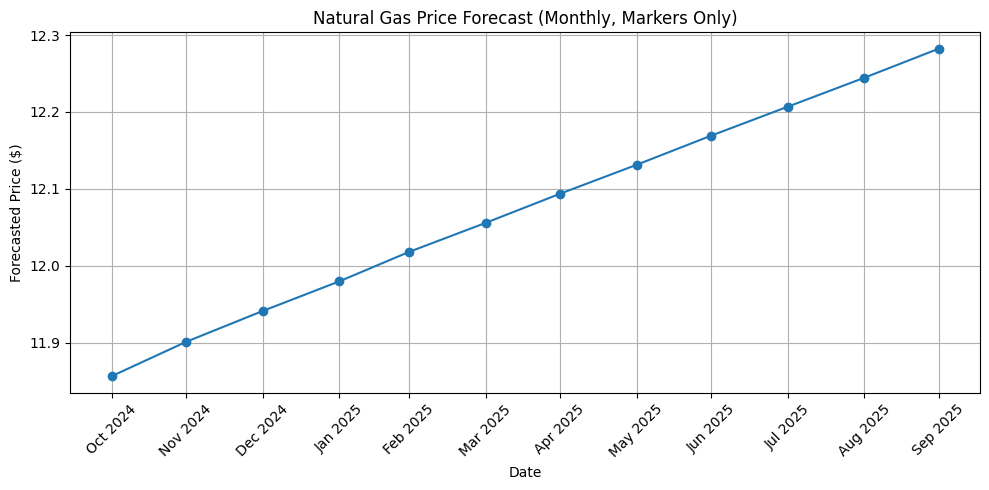

In [70]:

#Plot only markers
plt.figure(figsize=(10, 5))
plt.plot(x_dates, y_values, marker='o', linestyle='-')

#setting x-ticks at each monthly date, with formatted labels
#Format as 'Mon YYYY', e.g., 'Jan 2025'
labels = [d.strftime('%b %Y') for d in x_dates]
plt.xticks(ticks=x_dates, labels=labels, rotation=45)

# Labels and title
plt.xlabel("Date")
plt.ylabel("Forecasted Price ($)")
plt.title("Natural Gas Price Forecast (Monthly, Markers Only)")
plt.grid(True)
plt.tight_layout()
plt.show()


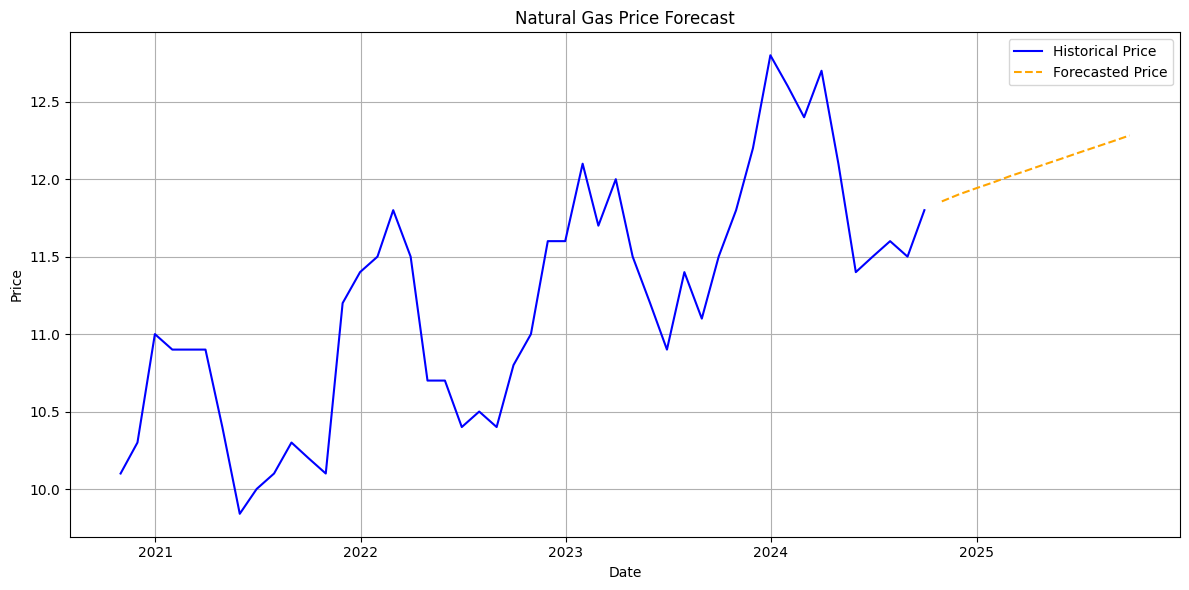

In [44]:
#Now we are comparing our model's forecast with historical price
# Plot historical prices
plt.figure(figsize=(12, 6))
plt.plot(Natgas.index, Natgas['Prices'], label='Historical Price', color='blue')

# Plot forecasted prices
plt.plot(forecast_monthly.index, forecast_monthly['Price_forecasted'], label='Forecasted Price', color='orange', linestyle='--')

# Customize the plot
plt.title('Natural Gas Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Conclusion & Key Findings
- **Forecast Insights**  
  - The prediction for the next 12 months suggests a modest upward trend in natural gas prices (means moving from around \$11.9 to \$12.3 over 12 months), with confidence intervals reflecting growing uncertainty further out.
  - Technical indicators (EMAs) captured smoothed trends effectively; their coefficients were highly significant, confirming their usefulness as predictors.

- **Practical Implications**  
  - For a quantitative analyst or energy market stakeholder, this suggests that short-term momentum or trend indicators (EMAs) can add value beyond a naive random-walk assumption.
  - However, the forecast should be taken with caution: structural shocks (e.g., geopolitical events, supply disruptions) are not captured by this model.

## Limitations

1. **Data Size & Frequency**  
   - Only 48 samples (monthly data for 4 years) limits model learning power, complexity and stability.  
   - More data (longer history or higher-frequency data) could help better identify patterns or seasonality.

2. **Model Assumptions**  
   - ARIMA/SARIMAX assumes linear relationships and normally distributed residuals; real market prices may exhibit non-linear dynamics and heavy tails.
   - No explicit seasonality term was included; if there is seasonal behavior (e.g., winter demand spikes), a seasonal component (SARIMA) or additional variables might be needed.

4. **Convergence Warnings**  
   - The SARIMAX model sometimes raised convergence warnings due to the small sample and multiple regressors. While diagnostics looked acceptable, results should be interpreted with caution.

5. **Forecast Uncertainty**  
   - Confidence intervals widen over time, further out forecasts become less reliable.  
   - We can use forecasts as a broad guide rather than exact predictions.


## Next Steps & Future Work

1. **Add More Exogenous Variables**  
   -  We can incorporate macro variables (inventory data, economic indicators, related commodity prices) to capture broader iimpact on price.
   - We also can include seasonality explicitly ( monthly or quarterly dummies) if data suggests recurring patterns.

2. **Expand Data**  
   - We can gather a longer history or higher-frequency data (weekly/daily) to improve model fitting and allow for richer model structures (SARIMA with seasonal terms).
   - If we wil use daily data, we will intraday factors or volatility measures aswell.

3. **Alternative Models**  
   - Experiment with models that handle non-linearity or regime changes:  
     - **Prophet** for automatic seasonality and holiday effects.  
     - **Machine Learning**: Random Forests or Gradient Boosting on lag features + technical indicators.  
     - **Neural Networks** (LSTM) if sufficient data is available.  
     - **Regime-Switching Models** (Markov-Switching) to capture structural breaks or shifts.

4. **Volatility Modeling**  
   - Integrate GARCH-type models to forecast volatility and incorporate this into confidence intervals or risk assessments.

5. **Backtesting & Validation**  
   - If possible, hold out a test set (the last 12 months) to evaluate forecast accuracy (MAPE, RMSE).  
   - Use rolling or expanding window validation to assess stability over time.



